In [78]:
class CurrentBoard:
  def __init__(self,setup_of_board = ['wwww','wwww','wwww','    ','    ','bbbb', 'bbbb', 'bbbb']):
      self.board = setup_of_board
      self.state = self.state_of_play()

  def display_board(self):
    print("-----------------")
    for row in range(8):
      c = self.board[row]
      if (row % 2) == 0:
        print("| |{}| |{}| |{}| |{}|".format(c[0], c[1],c[2],c[3]))
      else: 
        print("|{}| |{}| |{}| |{}| |".format(c[0], c[1],c[2],c[3]))
      print("-----------------")    

  def state_of_play(self):
    whites = 0
    blacks = 0
    for row in self.board:
      whites += row.count('w') + 2* row.count('W')
      blacks += row.count('b') + 2* row.count('B')
    
    self.evaluation = whites - blacks
    if whites == 0 :
      return 'b'
    if blacks == 0:
      return 'w'
    return 'U'

  def adjacent_squares(self, position, inc = 999):
    # inc = 1 for whites, inc = -1 for black, inc  =0 for kings
    # return a list of all possible positions reachable in 1 move from position

    if inc > 10:
      return self.adjacent_squares(position,inc = self.directionAt(position))
    if inc == 0:
        return self.adjacent_squares(position, inc = -1) + self.adjacent_squares(position,inc = 1)

    all_moves = []
    start_row = position[0]
    start_i = position[1]

    new_row = start_row+inc
    if (new_row>=0) and (new_row < 8):
      all_moves.append((new_row,start_i))
      if (start_row % 2) == 0:
        if (start_i<3):
          all_moves.append((new_row, start_i+1))
      else:
        if (start_i >0):
          all_moves.append((new_row, start_i-1))       

    return all_moves

  def playingAs(self, piece):
    if piece == 'W':
      return 'w'
    if piece == "B":
      return 'b'
    return piece

  def all_possible_moves_for(self,playing_colour): # all moves for "w" or "b"
    non_kill_boards = []
    kill_boards = []
    found_kill = False
    for row in range(8):
      for i in range(4):
        if self.playingAs(self.get_piece_at((row,i))) == playing_colour:
          new_non_kills, new_kills = self.construct_boards_for((row,i),found_kill)
          if len(new_kills) > 0:
            found_kill = True
            kill_boards += new_kills
          else:
            non_kill_boards += new_non_kills
    if found_kill:
      return kill_boards
    else:
      return non_kill_boards

  def get_piece_at(self, position):
    if position != None:
      return self.board[position[0]][position[1]]
    else:
      return None

  def row_for(self,position):
    return position[0]

  def i_for(self,position):
    return position[1]

  def jump_to(self, from_position, over_position):
    row_dir = self.row_for(over_position) - self.row_for(from_position)
    new_row = self.row_for(over_position) + row_dir
    if (new_row <0) or (new_row>7):
      return None
    if (new_row % 2) == 0:
      if (self.i_for(from_position) == self.i_for(over_position)):
        new_i = self.i_for(from_position) - 1
      else:
        new_i = self.i_for(from_position)  +1
    else:

      if (self.i_for(from_position) == self.i_for(over_position)):
        new_i = self.i_for(from_position) + 1
      else:
        new_i = self.i_for(from_position)  -1   
    if (new_i >=0) and (new_i<4):
      return (new_row,new_i)
   
  def all_kills(self,start_position, current_position,kill_list):
    all_kills_from_here = self.get_adjacent_kills(current_position, kill_list)
    all_completed_moves = []
    if (all_kills_from_here == []):
      if (kill_list == []):
        return []
      else:
        return [self.board_for(start_position, current_position,kill_list)]
    
    for kill in all_kills_from_here:
      all_completed_moves += self.all_kills(start_position,self.jump_to(current_position, kill), kill_list + [kill])

    return all_completed_moves

  def king_me(self,piece):
    if piece == 'w':
      return 'W'
    if piece == 'b':
      return 'B'
    return piece
  
  def board_for(self, from_position, to_position, kill_list):
    board_def = []
    remove_list = kill_list +[from_position]
  
    piece = self.get_piece_at(from_position)
    if (self.row_for(to_position) %7 ) == 0:
      piece = self.king_me(piece)
    for row_index in range(8):
      row = self.board[row_index]
      for empty_square in remove_list:
        if row_index == self.row_for(empty_square):
          row =  self.replace_at(row, self.i_for(empty_square) ,' ' ) 
      if row_index == self.row_for(to_position):

        row = self.replace_at(row, self.i_for(to_position) , piece )
      
      board_def.append(row)
    return CurrentBoard(board_def)

  def move_piece_to(self, from_position, to_position):
    return self.board_for(from_position,to_position,[from_position])


  def get_adjacent_kills(self,position,kill_list):
      piece  = self.get_piece_at(position)
      kills = []
      all_adjacent_squares = self.adjacent_squares(position)
      for square in all_adjacent_squares:
        if self.is_opponent_of(piece,self.get_piece_at(square)):
          if self.is_not_already_killed(square,kill_list) and self.get_piece_at( self.jump_to(position,square) ) == ' ':
            kills.append(square)
      return kills

  def is_not_already_killed(self,square, list_of_positions):
    return not (square in list_of_positions)

  def is_opponent_of(self,piece1,piece2):
    return (self.playingAs(piece1) != self.playingAs(piece2)) and (piece1 != ' ') and (piece2 != ' ')

  def replace_at(self,row_as_string, index, character):
    return row_as_string[:index] + character + row_as_string[index+1:]

  def construct_boards_for(self,  from_position , found_kill):
    non_kill_boards = []
    kill_boards = []

    kill_boards += self.all_kills(from_position,from_position,[])
    if not found_kill  and len(kill_boards)==0:
      to_position_list = self.adjacent_squares(from_position)
      for new_position in to_position_list:
        if self.get_piece_at(new_position) == " ":
          non_kill_boards.append(self.move_piece_to(from_position, new_position))

    return non_kill_boards, kill_boards

  def directionAt(self,position):
    piece = self.get_piece_at(position)
    color = self.playingAs(piece)
    inc  = 0 
    if piece == color:
      if piece == 'w':
        inc = 1
      else:
        inc = -1
    return inc

In [79]:
class Search_Tree_Node:
  def __init__(self, game, playing_char, ply = 0):
    self.children = []
    self.ply_depth = ply
    self.max_depth = 4
    self.value_is_assigned = False
    self.value = 999
    self.board_for_node = game
    self.playing = playing_char
    
    if self.board_for_node.state == "U":
      # Only generate children for the specified depth
      if self.ply_depth <= self.max_depth:
        self.generate_children()
    else: 
      if (self.ply_depth % 2) == 0:
        self.value = -1
      else:
        self.value = 1
    self.value_is_assigned = True

  def max_min_value(self):
    # If no value is assigned we will assign the max (or min) of the value of the children
    if self.value_is_assigned:
      return self.value
    else: 
      self.children = sorted(self.children, key=lambda x: x.max_min_value())

      if (self.ply_depth % 2) == 0:
        self.value = self.children[-1].value
      else:
        self.value = self.children[0].value
    return self.value

  def other_char(self, current):
    if current == "w":
      return "b"
    if current == "b":
      return "w"
    return " "

  def generate_children(self):
    for next_move in self.board_for_node.all_possible_moves_for(self.playing):
      self.children.append(Search_Tree_Node(next_move, self.other_char(self.playing), self.ply_depth + 1))

In [80]:
def run_game():
  current_game = CurrentBoard()

  # Do you want to play as white or black?
  # Black moves first in Checkers
  choice = input("Do you want to play as black: y/n? ")
  player_playing_b = (choice == "y") or (choice == "Y")
  if player_playing_b:
    player_this_turn = True
    player_playing = "b"
    computer_playing = "w"
  else:
    player_this_turn = False
    player_playing = "w"
    computer_playing = "b"

  # Game Loop
  while (current_game.state == "U"):
   # Display Current board (for player input)  
    current_game.display_board()
    if player_this_turn:
      new_moves = current_game.all_possible_moves_for(player_playing)
      for choice in range(len(new_moves)):
        print("\nEnter {} to make move below ".format(str(choice)))
        new_moves[choice].display_board()
      player_choice = input("\nYour choice ------> ")
      current_game = new_moves[int(player_choice)]
    else:
      print("")
      st = Search_Tree_Node(current_game, computer_playing)
      print("Computer's move")
      current_game = st.children[-1].board_for_node

    player_this_turn = not player_this_turn

    if current_game.state != "U":
      if current_game.state == "D":
        print("The game was a draw!")
      elif computer_playing == current_game.state:
        print("The computer wins the game!")
      else:
        print("You won against the computer!")
      current_game.display_board()
      break

In [81]:
run_game()

Streaming output truncated to the last 5000 lines.
|b| |b| |b| | | |
-----------------

Enter 7 to make move below 
-----------------
| |w| |w| |w| |w|
-----------------
|w| | | |w| |w| |
-----------------
| | | | | | | |b|
-----------------
| | | | |b| |b| |
-----------------
| |w| | | | | | |
-----------------
|b| | | |b| |b| |
-----------------
| |b| |b| | | | |
-----------------
|b| |b| |b| | | |
-----------------

Your choice ------> 6
-----------------
| |w| |w| |w| |w|
-----------------
|w| | | |w| |w| |
-----------------
| | | | | | | |b|
-----------------
| | | | |b| |b| |
-----------------
| | | |w| | | | |
-----------------
|b| | | |b| |b| |
-----------------
| |b| |b| | | | |
-----------------
|b| |b| |b| | | |
-----------------

Computer's move
-----------------
| |w| |w| |w| |w|
-----------------
|w| | | |w| |w| |
-----------------
| | | | | | | |b|
-----------------
| | |b| |b| |b| |
-----------------
| | | | | | | | |
-----------------
|b| | | | | |b| |
----------------

# Showing the ending of a game where the computer wins as black

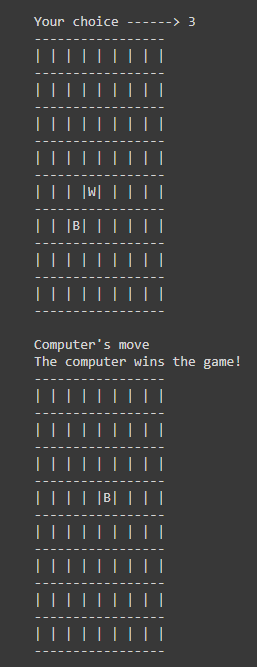